In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso

In [2]:
df=pd.read_csv('/rds/general/user/hsl121/home/hda_project/rq1/rq1_cleaned_no_ae.csv')
adverse=pd.read_excel('/rds/general/user/hsl121/home/hda_project/data/Adverse Events 6 Jan 2025_Prescribed_Completed Baseline PROMs.xlsx')

In [21]:

adverse.columns
print(adverse['Withdrawal'].isna().sum())
print(adverse['Withdrawal'].unique())
## One Hot Encoding for Adverse Events (just predictin yes or no adverse events)

def adverse_na(x):
    if pd.isna(x):
        return 'No'
    else:
        return x
def adverse_ohe(x):
    if x=='No':
        return 0
    else:
        return 1

adverse_cols= [col for col in adverse.columns
               if col not in ['SID', 'Prescribed', 'BaselinePROMS', 'Date', 'DaysFromStart']
               and not col.endswith('days')]


adverse[adverse_cols] = adverse[adverse_cols].applymap(adverse_na)
adverse[adverse_cols] = adverse[adverse_cols].applymap(adverse_ohe)



rename_dict = {col: f"{col}_adverse" for col in adverse_cols}

# Rename the columns in the adverse subset
selected_adverse = adverse[['SID'] + adverse_cols].rename(columns=rename_dict)
selected_adverse.shape
selected_adverse = selected_adverse.groupby('SID', as_index=False).max()


full_adverse = pd.merge(df, selected_adverse, on='SID', how='left')
full_adverse.to_csv("/rds/general/user/hsl121/home/hda_project/rq1/rq1_cleaned_yes_ae.csv", index=False) 

2399
[nan 'Moderate' 'Severe']


/var/tmp/pbs.1231401.pbs/ipykernel_3657807/3451916867.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adverse[adverse_cols] = adverse[adverse_cols].applymap(adverse_na)
/var/tmp/pbs.1231401.pbs/ipykernel_3657807/3451916867.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adverse[adverse_cols] = adverse[adverse_cols].applymap(adverse_ohe)


In [4]:
full_adverse.shape

(20593, 266)

In [5]:
# create binary col - if any of the adverse cols=1, then binary col =1, else =0
adverse_cols_renamed = [f"{col}_adverse" for col in adverse_cols]
full_adverse['adverse_binary'] = full_adverse[adverse_cols_renamed].sum(axis=1).gt(0).astype(int)
full_adverse = full_adverse.drop(columns=adverse_cols_renamed, axis=1)
full_adverse.to_csv("/rds/general/user/hsl121/home/hda_project/rq1/rq1_cleaned_adverse_binary.csv", index=False) 

Binary AE Added

In [18]:
df=pd.read_csv('/rds/general/user/hsl121/home/hda_project/rq1/rq1_cleaned_adverse_binary.csv')

In [12]:
df.columns.tolist()

['SID',
 'EQ5D_Round1',
 'EQ5D_Round2',
 'EQ5D_Round3',
 'EQ5D_Round4',
 'EQ5D_Round5',
 'EQ5D_Round6',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1',
 'insomniaEfficacyMeasure_Round1',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neuropathi

In [8]:
df.columns
drop=['EQ5D_Round2', 'EQ5D_Round3', 'EQ5D_Round4','EQ5D_Round5', 'EQ5D_Round6']
df=df.drop(columns=drop)

In [20]:
full=df.copy()

In [21]:
X=full.drop(['adverse_binary','SID'], axis=1)
y=full['adverse_binary']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")


Test MSE: 0.052
Test R²: 0.022


XGBoost

In [8]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum()  # handle imbalance
)

xgb_model.fit(X_train, y_train)


/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:22:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[3572  316]
 [ 185   46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3888
           1       0.13      0.20      0.16       231

    accuracy                           0.88      4119
   macro avg       0.54      0.56      0.54      4119
weighted avg       0.90      0.88      0.89      4119

ROC AUC Score: 0.662260835871947


Subsampling

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score


df=pd.read_csv('/rds/general/user/hsl121/home/hda_project/rq1/rq1_cleaned_adverse_binary.csv')
df.columns
drop=['EQ5D_Round2', 'EQ5D_Round3', 'EQ5D_Round4','EQ5D_Round5', 'EQ5D_Round6']
df=df.drop(columns=drop)

full=df.copy()

# 1. --- Train-test split ---
X = full.drop(['adverse_binary', 'SID'], axis=1)
y = full['adverse_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. --- Matching Function on configurable variables ---
def match_controls_to_cases(cases, controls, match_vars):
    scaler = StandardScaler()
    controls_scaled = scaler.fit_transform(controls[match_vars])
    cases_scaled = scaler.transform(cases[match_vars])

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(controls_scaled)
    _, indices = nn.kneighbors(cases_scaled)

    matched_controls = controls.iloc[indices.flatten()].copy()
    matched_controls['matched_to'] = cases.index.values
    return matched_controls

# 3. --- Generate matched datasets ---
train_df = X_train.copy()
train_df['adverse_binary'] = y_train

cases = train_df[train_df['adverse_binary'] == 1].dropna()
controls = train_df[train_df['adverse_binary'] == 0].dropna()

match_vars = ['Age', 'Sex', 'weight', 'height']  # match on these features

subsampled_datasets = []
for i in range(5):
    ctrl_sample = controls.sample(frac=1, random_state=i).reset_index(drop=True)
    matched_controls = match_controls_to_cases(cases, ctrl_sample, match_vars)
    matched_df = pd.concat([cases, matched_controls])
    subsampled_datasets.append(matched_df)

# 4. --- Evaluate models on the same test set ---
results = []

for i, df_sub in enumerate(subsampled_datasets):
    X_train_sub = df_sub.drop(columns=['adverse_binary', 'matched_to'], errors='ignore')
    y_train_sub = df_sub['adverse_binary']

    # Define models
    models = {
        "LogisticRegression": LogisticRegression(max_iter=500),
        "RandomForest": RandomForestClassifier(n_estimators=1000, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "NeuralNet": MLPClassifier(hidden_layer_sizes=(16,), max_iter=100, random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train_sub, y_train_sub)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_prob)

        results.append({
            'Repeat': i + 1,
            'Model': model_name,
            'F1_Score': round(f1, 3),
            'ROC_AUC': round(roc, 3)
        })

# 5. --- Return results as DataFrame ---
results_df = pd.DataFrame(results)
print(results_df)


/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:44:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reach

    Repeat               Model  F1_Score  ROC_AUC
0        1  LogisticRegression     0.153    0.656
1        1        RandomForest     0.162    0.687
2        1             XGBoost     0.150    0.657
3        1           NeuralNet     0.131    0.588
4        2  LogisticRegression     0.155    0.664
5        2        RandomForest     0.170    0.691
6        2             XGBoost     0.152    0.641
7        2           NeuralNet     0.128    0.585
8        3  LogisticRegression     0.151    0.652
9        3        RandomForest     0.170    0.687
10       3             XGBoost     0.158    0.665
11       3           NeuralNet     0.126    0.577
12       4  LogisticRegression     0.152    0.655
13       4        RandomForest     0.163    0.688
14       4             XGBoost     0.146    0.646
15       4           NeuralNet     0.131    0.594
16       5  LogisticRegression     0.150    0.654
17       5        RandomForest     0.167    0.687
18       5             XGBoost     0.150    0.652


/rds/general/user/hsl121/home/anaconda3/envs/TDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


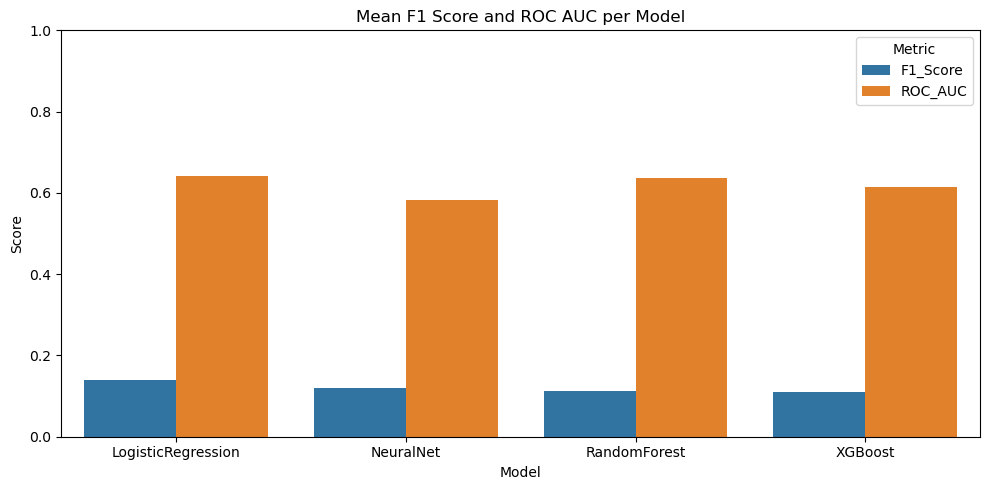

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to long format
plot_df = agg_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric')
plt.title('Mean F1 Score and ROC AUC per Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [16]:
for i, df in enumerate(subsampled_datasets):
    print(f"Subsample {i+1} class counts:")
    print(df['adverse_binary'].value_counts(), "\n")

Subsample 1 class counts:
adverse_binary
1    873
0    873
Name: count, dtype: int64 

Subsample 2 class counts:
adverse_binary
1    873
0    873
Name: count, dtype: int64 

Subsample 3 class counts:
adverse_binary
1    873
0    873
Name: count, dtype: int64 

Subsample 4 class counts:
adverse_binary
1    873
0    873
Name: count, dtype: int64 

Subsample 5 class counts:
adverse_binary
1    873
0    873
Name: count, dtype: int64 



In [28]:
train_df['adverse_binary'].value_counts()

adverse_binary
0    15601
1      873
Name: count, dtype: int64

Grid Search for Random Forest